#### NBA ANALYTICS: What makes a team win?
Final Project Report Code <br>
Konstantina TSILIFONI - konstantina.tsilifoni@student-cs.com <br>
Firas ABO MRAD - firas.abomrad@student-cs.fr<br>
Karim EL HAGE - karim.elhage@student-cs.fr


## Project description

### NBA Basketball Data Analysis:
We choose to analyze the NBA basketball data from the last five years to highlight correlations between statistics that would be useful for draft preparation and team training. We carefully select needed data, prepare the dataset by preprocessing and handling missing values, and then analyze the data by visualizing the data and finding correlations between statistics. We also use machine learning to predict a team's performance given the per-game statistics as well as aggregate player information.
We hope that our analysis can help the NBA teams to make better decisions in the draft and training. 
**Analysis will be carried on seasons data back to season 2015.**

## Data Source:
We use two datasets from Kaggle: [NBA Players](https://www.kaggle.com/datasets/justinas/nba-players-data) and [Basketball Dataset](https://www.kaggle.com/datasets/wyattowalsh/basketball). We mainly use the second dataset, which contains the per-game statistics of teams throughout the NBA's history. We also use the first dataset to get the player's teams per year since the second dataset only contains the draft team and the last team of a player.

## Data setup

#### Import needed libraries :
Start the markdown table


sqlite for database, pandas for data manipulation, matplotlib and seaborn for visualization
| Library 	| import command 	| Description |
|:---:	    |:---:	            |:---:	      |
| sqlite3 	| import sqlite3 	| Database manipulation 	|
| pandas 	| import pandas 	| Dataframe manipulation and data preparation 	|
| matplotlib 	| import matplotlib.pyplot as plt 	| Visualization 	|
| seaborn 	| import seaborn as sns 	| Visualization 	|
| numpy 	| import numpy as np 	| Dataframe manipulation 	|
| torch 	| import torch 	| Neural networks |

In [1]:
import sqlite3 as sql
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import torch
import numpy as np
import xgboost as xgb
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score,f1_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error as MSE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Open the database and get the list of tables

In [3]:
path = "/content/drive/MyDrive/FML - Final Project/Assignment 3"

In [4]:
!unzip "/content/drive/MyDrive/FML - Final Project/Assignment 3/basketball.sqlite.zip"
connection = sql.connect('basketball.sqlite')
list_of_tables = connection.execute('SELECT name from sqlite_master where type= "table"').fetchall()
list_of_tables

Archive:  /content/drive/MyDrive/FML - Final Project/Assignment 3/basketball.sqlite.zip
  inflating: basketball.sqlite       


[('Player',),
 ('Team',),
 ('Team_Attributes',),
 ('Team_History',),
 ('Player_Attributes',),
 ('Game_Officials',),
 ('Game_Inactive_Players',),
 ('Team_Salary',),
 ('Player_Salary',),
 ('Draft',),
 ('Draft_Combine',),
 ('Player_Photos',),
 ('Player_Bios',),
 ('Game',),
 ('News',),
 ('News_Missing',)]

#### Get the draft, draft_combine, and game tables, they are the ones we are interested in.

In [5]:
game_df = pd.read_sql_query("SELECT * FROM Game", connection) #Dataframe with all game data including statistics
draft_df = pd.read_sql_query("SELECT * FROM Draft", connection) #Dataframe with general player info being drafted to teams
draft_combine_df = pd.read_sql_query("SELECT * FROM Draft_Combine", connection) #Dataframe with drafted player attributes as well performances during the NBA "Combine" tests

#### Draft Combine Analysis

In [7]:
draft_combine_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1395 entries, 0 to 1394
Columns: 116 entries, yearCombine to setOffDribBreakRightCollegePct
dtypes: float64(84), int64(1), object(31)
memory usage: 1.2+ MB


In [8]:
combine_drafted = draft_df.merge(draft_combine_df, on='idPlayer', how='outer')

In [9]:
dataColumns = ['heightWOShoesInches',          # height without shoes
    'weightLBS',                    # weight in pounds
    'wingspanInches',               # wingspan in inches
    'reachStandingInches',          # reach standing in inches
    'verticalLeapStandingInches',   # vertical leap standing in inches
    'verticalLeapMaxInches',        # vertical leap max in inches
    'repsBenchPress135',            # reps of bench press at 135 lbs
    'timeLaneAgility',              # time in lane agility
    'timeThreeQuarterCourtSprint',  # time in three quarter court sprint
    'timeModifiedLaneAgility',      # time in modified lane agility
    'lengthHandInches',             # length of hand in inches
    'widthHandInches',              # width of hand in inches
    'pctBodyFat'                    # percent body fat
    ]
feature_list = [
    'idPlayer',                     # unique player id
    'idTeam',                       # unique team id
    'yearDraft',                    # year drafted
] + dataColumns
    
df_to_save = combine_drafted.copy(deep=True) #takes a copy of the merged dataframe of drafted players and their combine performances
df_to_save = df_to_save[feature_list] #takes only features of interes
df_to_save.to_csv('drafted_players.csv', index=False) #saves features of interest in csv file

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


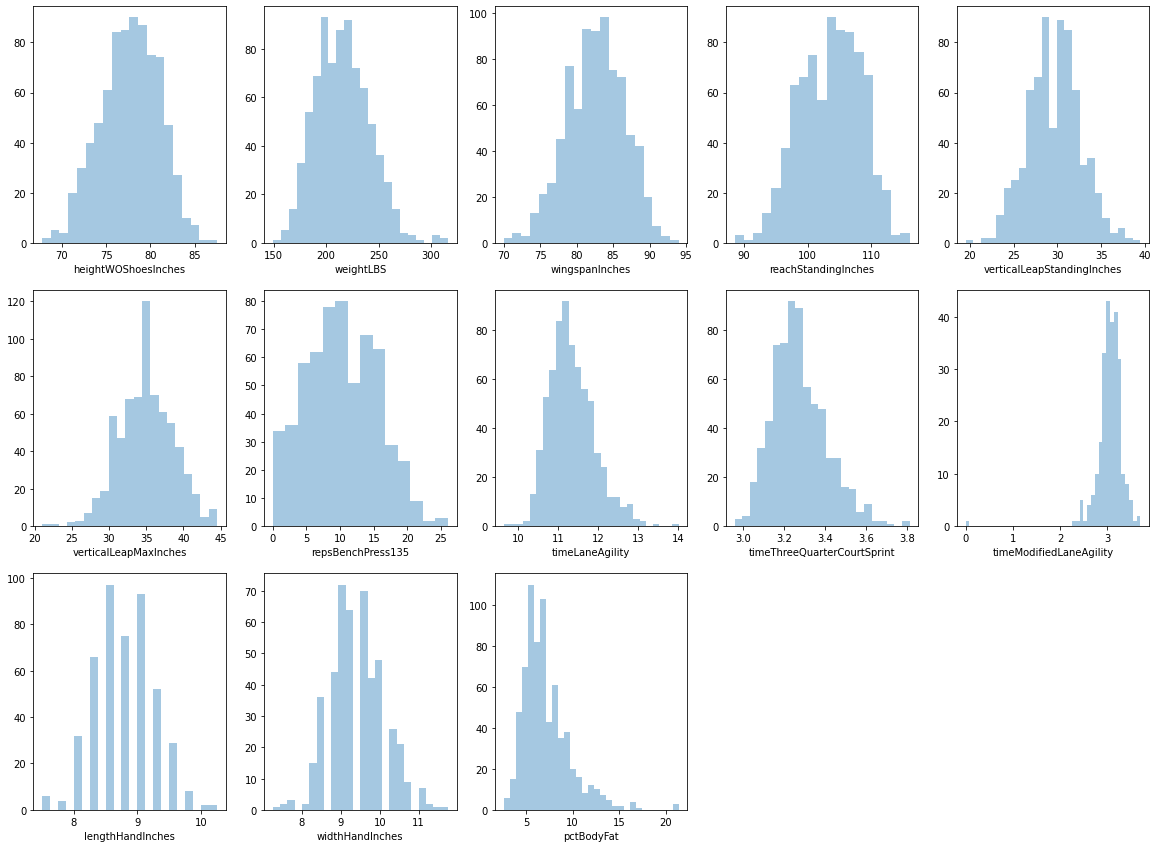

In [10]:
nPlots = len(dataColumns) #features of interest from the merged dataframe of drafted player & combine performance
nRows = 4
nCols = 5
i = 0
plt.figure(figsize=(20, 20))
for column in dataColumns:
    plt.subplot(nRows, nCols, i+1) 
    sns.distplot(df_to_save[column][df_to_save.yearDraft > 1994].dropna(), kde=False)
    i += 1
plt.show()

The majority of distributions are acceptable for analysis with a few minority that have skewed results. The above is repeated with looking at the log of the distribution

In [11]:
(df_to_save[df_to_save.yearDraft > 1994].isna().sum()/len(df_to_save[df_to_save.yearDraft > 1994]))*100

idPlayer                        0.000000
idTeam                          0.000000
yearDraft                       0.000000
heightWOShoesInches            48.582474
weightLBS                      48.711340
wingspanInches                 48.518041
reachStandingInches            48.582474
verticalLeapStandingInches     54.961340
verticalLeapMaxInches          55.025773
repsBenchPress135              61.597938
timeLaneAgility                55.541237
timeThreeQuarterCourtSprint    55.283505
timeModifiedLaneAgility        83.311856
lengthHandInches               69.974227
widthHandInches                69.974227
pctBodyFat                     54.832474
dtype: float64

There is a significant number of missing values accross most of the features. It is unlikely the data can be used for analysis and would need to be discarded. Data is only used starting 1994 since the oldest player in 2015 season was drafted in 1994.

#### Analysis of Game Statistics

In [ ]:
gameCols = game_df.columns
gameCols

Index(['GAME_ID', 'SEASON_ID', 'TEAM_ID_HOME', 'TEAM_ABBREVIATION_HOME',
       'TEAM_NAME_HOME', 'GAME_DATE', 'MATCHUP_HOME', 'WL_HOME', 'MIN_HOME',
       'FGM_HOME',
       ...
       'LAST_GAME_VISITOR_TEAM_CITY1', 'LAST_GAME_VISITOR_TEAM_POINTS',
       'HOME_TEAM_WINS', 'HOME_TEAM_LOSSES', 'SERIES_LEADER',
       'VIDEO_AVAILABLE_FLAG', 'PT_AVAILABLE', 'PT_XYZ_AVAILABLE',
       'HUSTLE_STATUS', 'HISTORICAL_STATUS'],
      dtype='object', length=149)

#### We get the columns for each of the home and away teams, indicated in the next list:

In [ ]:
XMetaCols = [
    "SEASON_ID",
    "GAME_DATE",
    "GAME_ID",
]

XTeamCols = ['TEAM_ID',     # unique team id
 'FG_PCT',             #field goal percentage
 'FGA',              # field goal attempted
 'FGM',             #field goal made
 'FG3M',            #3-point field goal made
 'FG3A',            #3-point field goal attempted
 'FG3_PCT',             # 3-point field goal percentage
 'FT_PCT',              # free throw percentage
 'OREB',                # offensive rebounds
 'DREB',                # defensive rebounds
 'AST',                 # assists
 'STL',                 # steals
 'BLK',                 # blocks
 'PF',                  # personal fouls
 'PTS_OFF_TO'          #Points from Turnover
 ]

YTeamCols = [
 'WL',					# win/loss
 'PTS'					# points
]

### Note: The column names are NOT the same used in the database, we need to append "_HOME" or "_AWAY" to the column names to differentiate between the home and away teams.

#### Build the column lists for each of the home and away teams

In [ ]:
XHomeTeamCols = [col + '_HOME' for col in XTeamCols]
XAwayTeamCols = [col + '_AWAY' for col in XTeamCols]
YHomeTeamCols = [col + '_HOME' for col in YTeamCols]
YAwayTeamCols = [col + '_AWAY' for col in YTeamCols]
#add turnover stats for both teams
allColsHome = XMetaCols + XHomeTeamCols + YHomeTeamCols + ['TOV_HOME'] + ['TOV_AWAY']
allColsAway = XMetaCols + XAwayTeamCols + YAwayTeamCols + ['TOV_HOME'] + ['TOV_AWAY']
allHomeGames = game_df[allColsHome]
# rename columns to remove _HOME
#rename TOV_AWAY column
allHomeGames.rename(columns={'TOV_AWAY':'TOV_FORCED'}, inplace=True)
allHomeGames.columns = [col.replace('_HOME', '') for col in allHomeGames.columns]
allAwayGames = game_df[allColsAway]
# switch turnover column names properly since now focus is on away team
allAwayGames.rename(columns={'TOV_HOME':'TOV_FORCED'}, inplace=True)
# rename columns to remove _AWAY
allAwayGames.columns = [col.replace('_AWAY', '') for col in allAwayGames.columns]

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
allHomeGames.head()

,SEASON_ID,GAME_DATE,GAME_ID,TEAM_ID,FG_PCT,FGA,FGM,FG3M,FG3A,FG3_PCT,...,DREB,AST,STL,BLK,PF,PTS_OFF_TO,WL,PTS,TOV,TOV_FORCED
0,21946,1946-11-01,0024600001,1610610035,NaN,None,25.0,None,None,NaN,...,None,None,None,None,NaN,None,L,66,None,None
1,21946,1946-11-02,0024600003,1610610034,0.339,59.0,20.0,None,None,NaN,...,None,None,None,None,21.0,None,W,56,None,None
2,21946,1946-11-02,0024600004,1610610025,NaN,None,21.0,None,None,NaN,...,None,None,None,None,20.0,None,W,63,None,None
3,21946,1946-11-02,0024600002,1610610032,NaN,None,21.0,None,None,NaN,...,None,None,None,None,NaN,None,W,59,None,None
4,21946,1946-11-02,0024600005,1610610028,NaN,None,10.0,None,None,NaN,...,None,None,None,None,NaN,None,L,33,None,None


### Instead of having two different tables for the home and away teams, we can merge them into one table, and add a column to indicate whether the team is home or away.

In [ ]:
allHomeGames['IS_HOME_GAME'] = 1
allAwayGames['IS_HOME_GAME'] = 0
allGames = pd.concat([allHomeGames, allAwayGames], ignore_index=True)

<ipython-input-9-d898cd41cdfc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allHomeGames['IS_HOME_GAME'] = 1
<ipython-input-9-d898cd41cdfc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allAwayGames['IS_HOME_GAME'] = 0


In [ ]:
allGames.head()

,SEASON_ID,GAME_DATE,GAME_ID,TEAM_ID,FG_PCT,FGA,FGM,FG3M,FG3A,FG3_PCT,...,AST,STL,BLK,PF,PTS_OFF_TO,WL,PTS,TOV,TOV_FORCED,IS_HOME_GAME
0,21946,1946-11-01,0024600001,1610610035,NaN,None,25.0,None,None,NaN,...,None,None,None,NaN,None,L,66,None,None,1
1,21946,1946-11-02,0024600003,1610610034,0.339,59.0,20.0,None,None,NaN,...,None,None,None,21.0,None,W,56,None,None,1
2,21946,1946-11-02,0024600004,1610610025,NaN,None,21.0,None,None,NaN,...,None,None,None,20.0,None,W,63,None,None,1
3,21946,1946-11-02,0024600002,1610610032,NaN,None,21.0,None,None,NaN,...,None,None,None,NaN,None,W,59,None,None,1
4,21946,1946-11-02,0024600005,1610610028,NaN,None,10.0,None,None,NaN,...,None,None,None,NaN,None,L,33,None,None,1


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


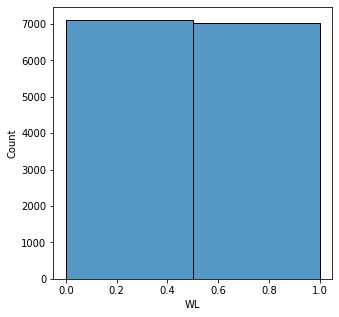

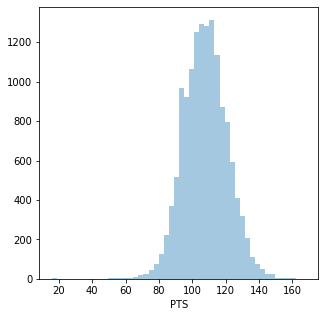

In [ ]:
plt.figure(figsize = (5,5))
sns.histplot(allGames["WL"][allGames.SEASON_ID.astype(int) > 22014].dropna(),bins = 2)
plt.figure(figsize = (5,5))
sns.distplot(allGames["PTS"][allGames.SEASON_ID.astype(int) > 22014].dropna(), kde=False)

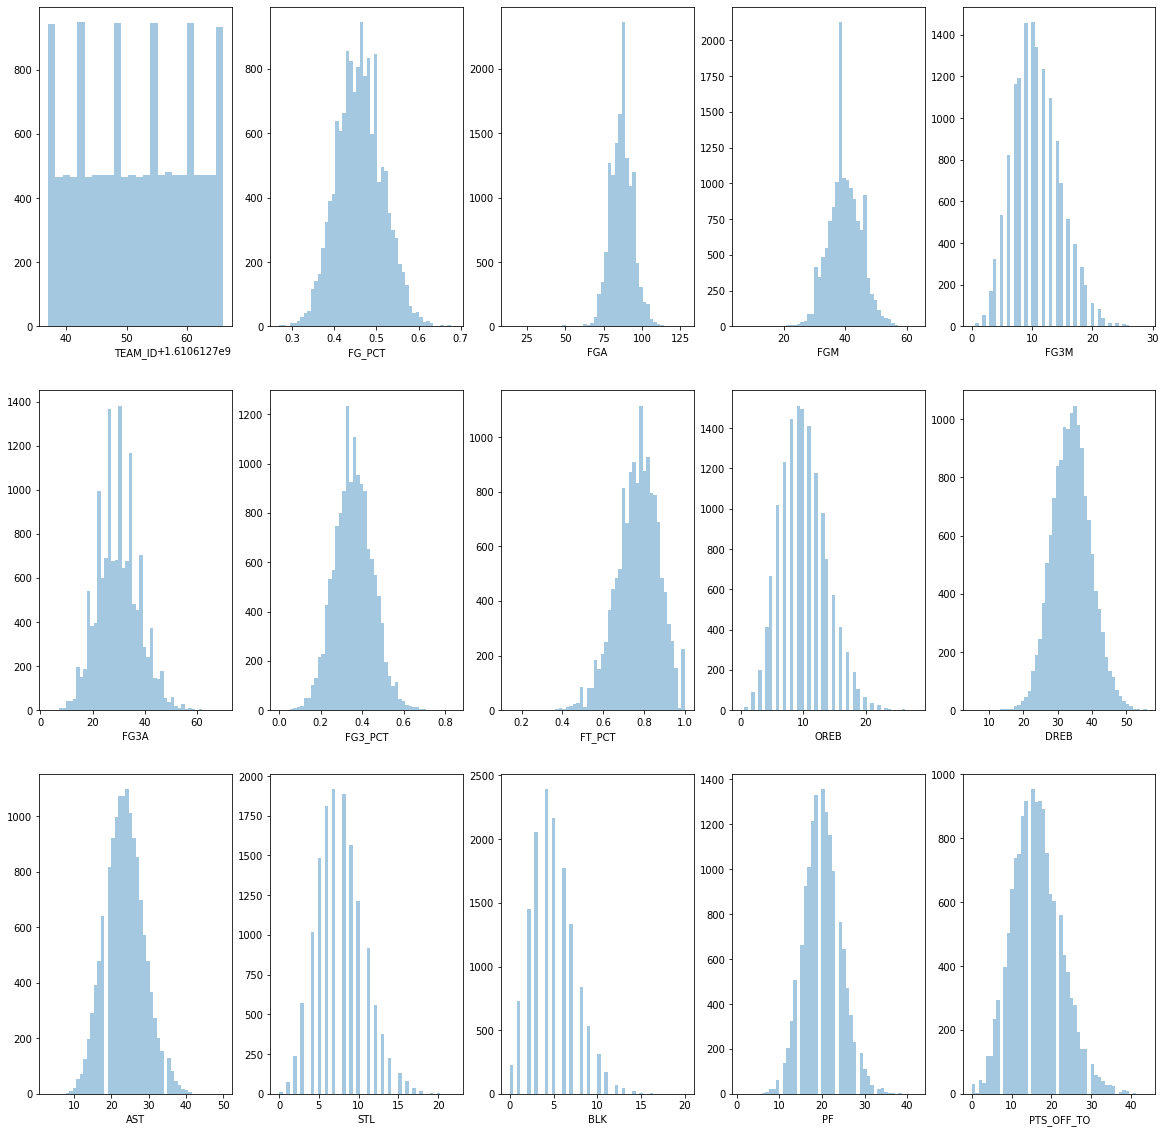

In [ ]:
nPlots = len(XTeamCols)
nRows = 3
nCols = 5
i = 0
plt.figure(figsize=(20, 20))
for column in XTeamCols:
    plt.subplot(nRows, nCols, i+1)    
    sns.distplot(allGames[column][allGames.SEASON_ID.astype(int) > 22014].dropna(), kde=False)
    i += 1
plt.show()

In [ ]:
# Make the WL column binary
allGames['WL'] = allGames['WL'].apply(lambda x: 1 if x == 'W' else 0)

### Now we can throw away old games that are not in the last five years.

In [ ]:
lastFiveSeasons = [2019, 2018, 2017, 2016, 2015]
oldestSeasonProcessed = lastFiveSeasons[-1]
allGames['GAME_DATE'] = pd.to_datetime(allGames['GAME_DATE'])
# Throw away games before oldestSeasonProcessed
allGames = allGames[allGames['GAME_DATE'].dt.year >= oldestSeasonProcessed]

In [ ]:
(allGames.isna().sum()/len(allGames))*100

SEASON_ID       0.000000
GAME_DATE       0.000000
GAME_ID         0.000000
TEAM_ID         0.000000
FG_PCT          0.000000
FGA             0.000000
FGM             0.000000
FG3M            0.000000
FG3A            0.000000
FG3_PCT         0.000000
FT_PCT          0.000000
OREB            0.000000
DREB            0.000000
AST             0.000000
STL             0.000000
BLK             0.000000
PF              0.000000
PTS_OFF_TO      0.140701
WL              0.000000
PTS             0.000000
TOV             0.000000
TOV_FORCED      0.000000
IS_HOME_GAME    0.000000
dtype: float64

In [ ]:
# Some entries are "None", we replace them with 0
allGames = allGames.replace('None', 0)
# Some entries are "nan", we replace them with 0
allGames = allGames.replace(np.nan, 0)
# Make sure all columns (except date) are numeric; the season_ID is already numeric, so we only need to convert columns starting from GAME_ID
allGames[allGames.columns[2:]] = allGames[allGames.columns[2:]].apply(pd.to_numeric)

In [ ]:
# Remove meta columns
allGamesPureData = allGames.drop(columns=['SEASON_ID', 'GAME_DATE', 'GAME_ID', 'TEAM_ID'])

#### Additionally, we aggregate the performance data for each team per season.

In [ ]:
for season in lastFiveSeasons:
    print("In the year {}, there was {} games in the NBA".format(season, allGamesPureData[allGamesPureData['IS_HOME_GAME'] == 1].shape[0]))

In the year 2019, there was 7818 games in the NBA
In the year 2018, there was 7818 games in the NBA
In the year 2017, there was 7818 games in the NBA
In the year 2016, there was 7818 games in the NBA
In the year 2015, there was 7818 games in the NBA


## Tasks

## Feature engineering

In [ ]:
allGamesPureData.head()

,FG_PCT,FGA,FGM,FG3M,FG3A,FG3_PCT,FT_PCT,OREB,DREB,AST,STL,BLK,PF,PTS_OFF_TO,WL,PTS,TOV,TOV_FORCED,IS_HOME_GAME
54630,0.418,91,38.0,8,15,0.533,0.880,13,33,22,7,18,19.0,11.0,1,106,7,13,1
54631,0.462,91,42.0,7,24,0.292,0.727,15,23,22,12,6,24.0,21.0,0,107,14,20,1
54632,0.533,92,49.0,12,28,0.429,0.800,14,31,35,8,8,18.0,11.0,1,126,9,17,1
54633,0.531,81,43.0,6,19,0.316,0.737,5,33,24,10,8,28.0,13.0,0,106,14,12,1
54634,0.352,91,32.0,10,24,0.417,0.500,17,30,18,13,4,15.0,14.0,0,81,14,17,1


In [ ]:
allGamesPureData['FG2M'] = allGamesPureData['FGM'] - allGamesPureData['FG3M']
allGamesPureData['FG2A'] = allGamesPureData['FGA'] - allGamesPureData['FG3A']
allGamesPureData['FG2_PCT'] = round(allGamesPureData['FG2M'] / allGamesPureData['FG2A'],3)
allGamesPureData = allGamesPureData.drop(columns=['FGM','FG3M','FGA','FG3A','FG_PCT','FG2A','FG2M'])
allGamesPureData['TOV_EXP_RATIO'] = allGamesPureData['PTS_OFF_TO']/allGamesPureData['TOV_FORCED']
allGamesPureData = allGamesPureData.drop(columns=['PTS_OFF_TO'])
allGamesPureData.head()

,FG3_PCT,FT_PCT,OREB,DREB,AST,STL,BLK,PF,WL,PTS,TOV,TOV_FORCED,IS_HOME_GAME,FG2_PCT,TOV_EXP_RATIO
54630,0.533,0.880,13,33,22,7,18,19.0,1,106,7,13,1,0.395,0.846154
54631,0.292,0.727,15,23,22,12,6,24.0,0,107,14,20,1,0.522,1.050000
54632,0.429,0.800,14,31,35,8,8,18.0,1,126,9,17,1,0.578,0.647059
54633,0.316,0.737,5,33,24,10,8,28.0,0,106,14,12,1,0.597,1.083333
54634,0.417,0.500,17,30,18,13,4,15.0,0,81,14,17,1,0.328,0.823529


### TASK 1: Find the correlation between the statistics each game and its result.

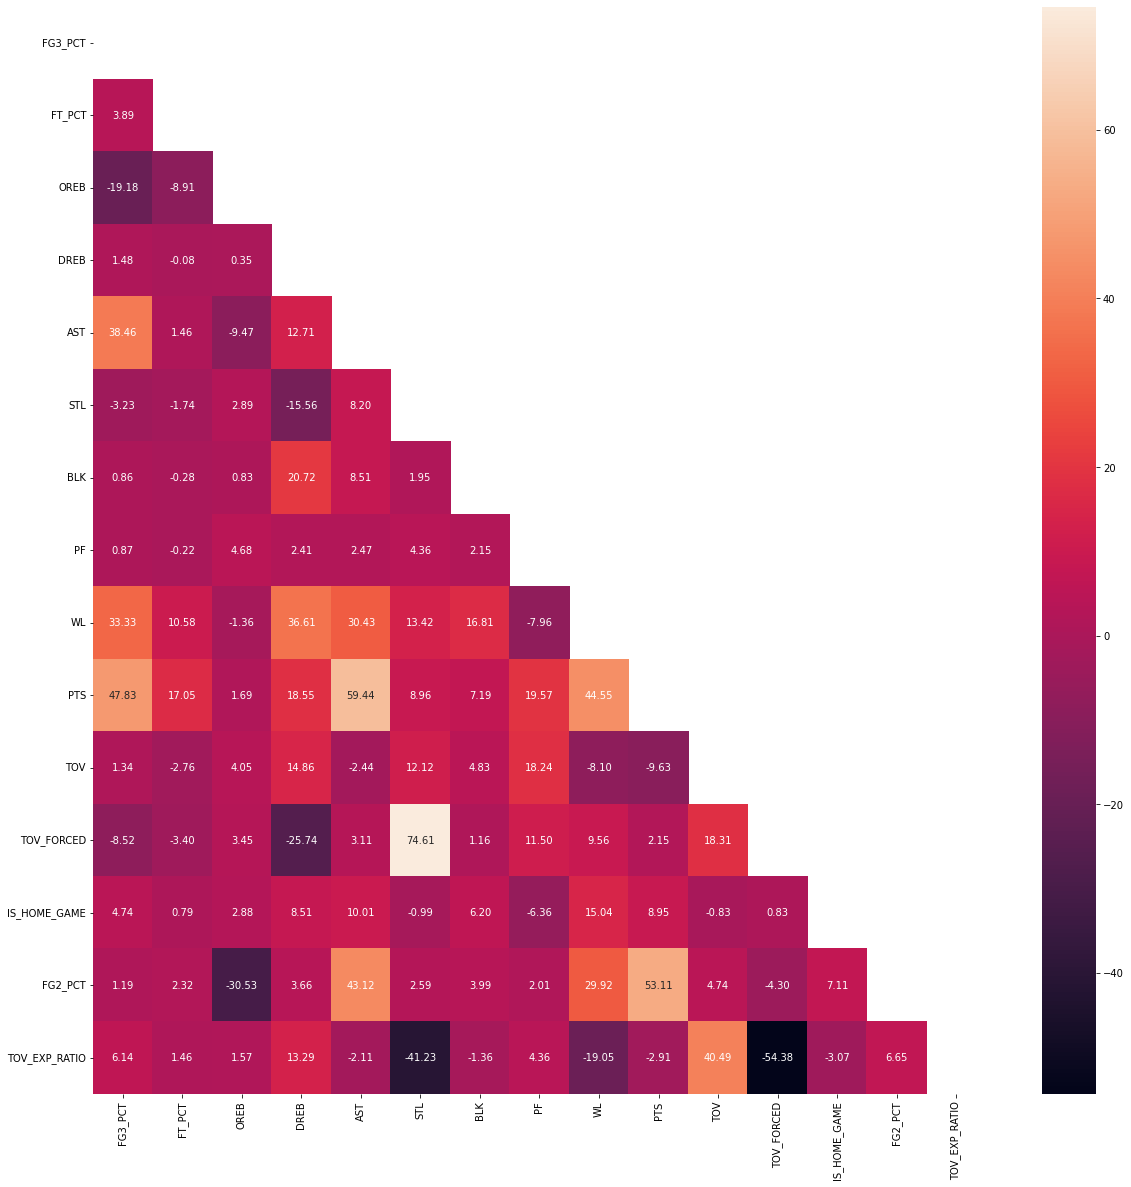

In [ ]:
# Compute correlation matrix between all columns and WL
corr = allGamesPureData.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr* 100, annot=True, fmt=".2f",mask = np.triu(corr))

In [ ]:
allGamesPureData.describe()

,FG3_PCT,FT_PCT,OREB,DREB,AST,STL,BLK,PF,WL,PTS,TOV,TOV_FORCED,IS_HOME_GAME,FG2_PCT,TOV_EXP_RATIO
count,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000,15636.000000
mean,0.356747,0.767416,10.157329,33.877974,23.428690,7.690714,4.854375,20.092543,0.497442,107.127654,14.158416,14.158416,0.500000,0.511836,1.253334
std,0.092267,0.103512,3.731310,5.468994,5.186768,2.948967,2.507340,4.349866,0.500009,13.162474,3.968783,3.968783,0.500016,0.071664,0.653538
min,0.000000,0.143000,0.000000,5.000000,3.000000,0.000000,0.000000,1.000000,0.000000,16.000000,1.000000,1.000000,0.000000,0.226000,0.000000
25%,0.294000,0.700000,8.000000,30.000000,20.000000,6.000000,3.000000,17.000000,0.000000,98.000000,11.000000,11.000000,0.000000,0.463000,0.823529
50%,0.355000,0.773000,10.000000,34.000000,23.000000,7.000000,5.000000,20.000000,0.000000,107.000000,14.000000,14.000000,0.500000,0.509000,1.133333
75%,0.417000,0.840000,13.000000,37.000000,27.000000,10.000000,6.000000,23.000000,1.000000,116.000000,17.000000,17.000000,1.000000,0.559000,1.545455
max,0.842000,1.000000,38.000000,56.000000,50.000000,22.000000,20.000000,42.000000,1.000000,168.000000,31.000000,31.000000,1.000000,0.800000,16.000000


In [ ]:
data_columns = list(allGamesPureData.columns)
cat_features = ['IS_HOME_GAME']
target_var = ['WL','PTS']
num_features = [column for column in data_columns if column not in cat_features+target_var]

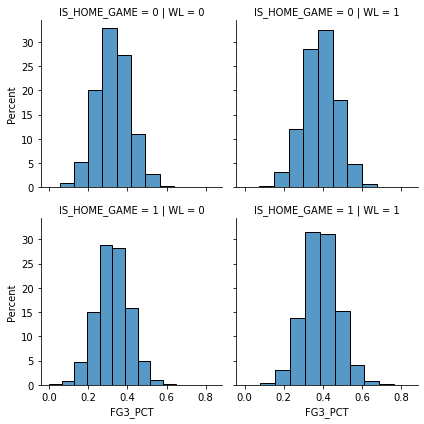

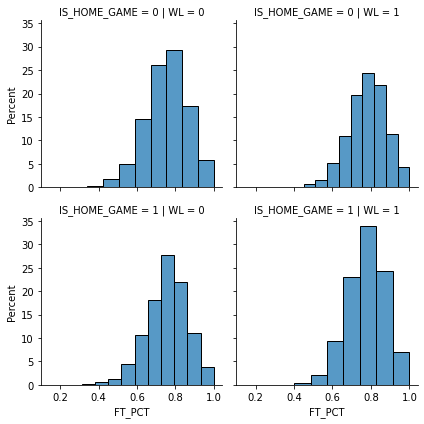

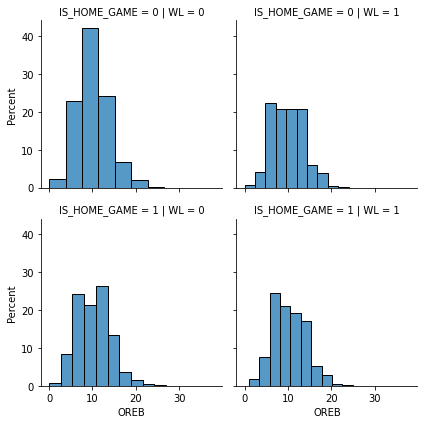

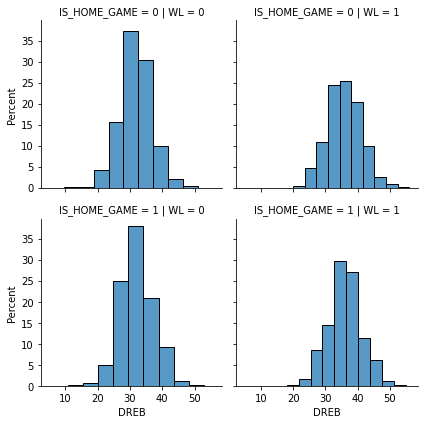

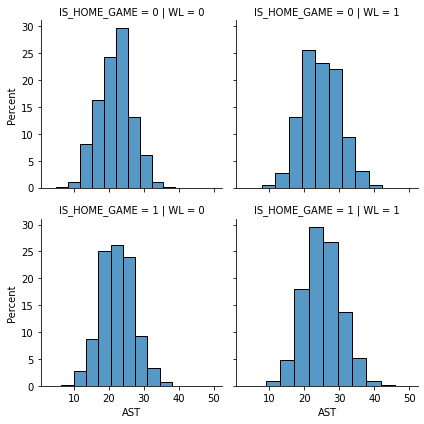

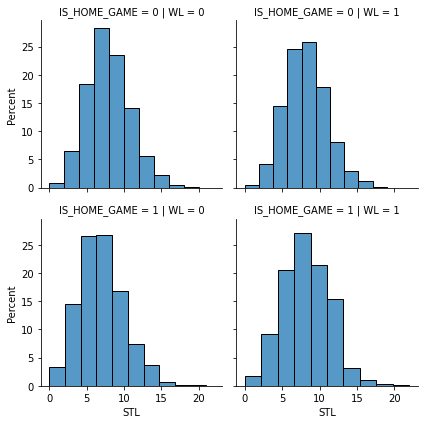

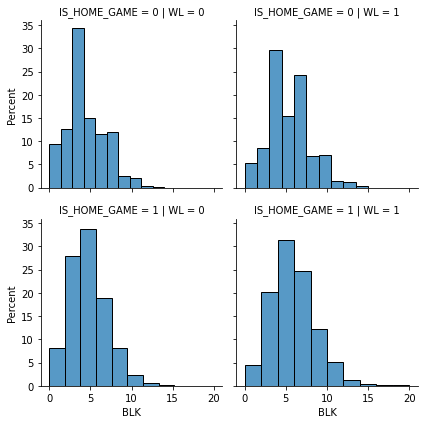

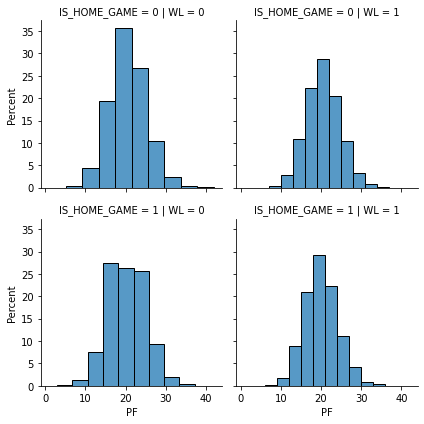

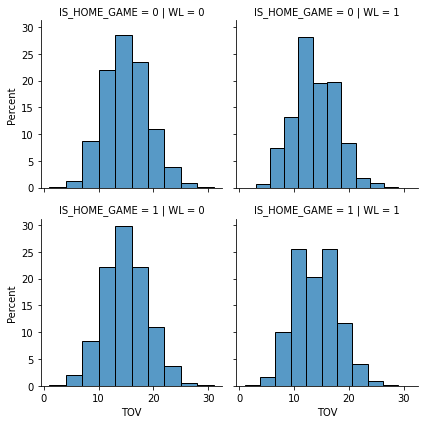

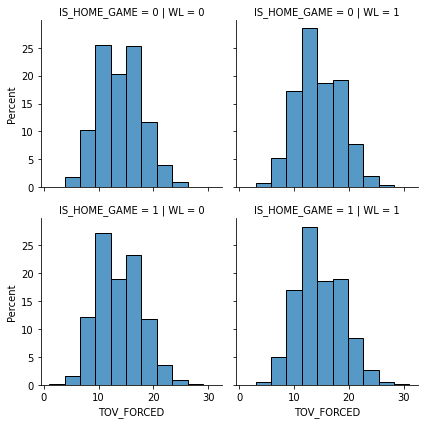

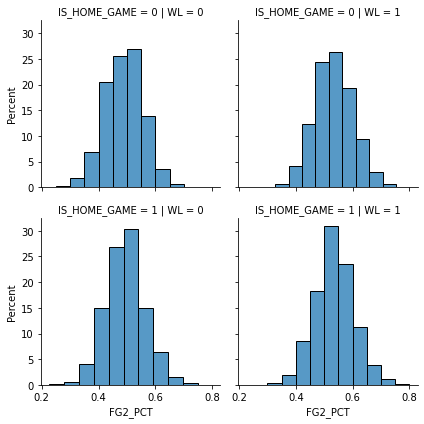

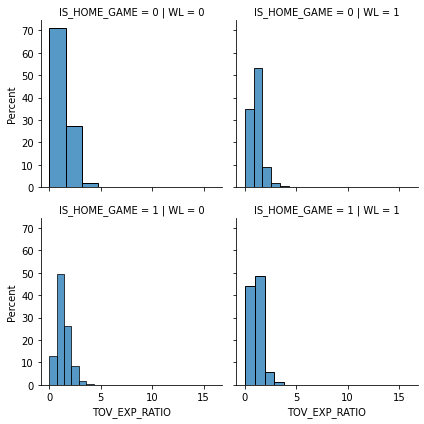

In [ ]:
#Plotting the features against WL
for column in allGamesPureData.drop(columns=['WL', 'PTS','IS_HOME_GAME']).columns:
    sea = sns.FacetGrid(allGamesPureData, row = "IS_HOME_GAME", col = "WL")
    sea.map(sns.histplot, column, stat="percent", bins = 10)


Summary of the results:
1. The home team wins more than the away team by a large margin (15% more wins for the home team).
2. Assists, Field Goal Percentage, 3-Point Percentage, and the number of defensive rebounds are the most important statistics for winning a game.
3. Assists are directly related to the Field Goal and 3-Point Percentages.
4. Offensive rebounds and team rebounds in general are negatively correlated with the field goal and free throw percentages, respectively.
5. Foulds yield more points but are more likely to lead to a loss.
6. Blocks, steals, and turnovers explain some of the variance in the winning percentage, but they are more related to the number of defensive rebounds, which is natural considering that they give the team a big change in momentum.
7. There is no clear visual trend in the features that could influence a W/L outcome. 

### TASK 2: Predict the W/L and the number of points for each team, given the statistics of the game.

#### This is a straightforward task given that the data is strictly correlated with the result, and it requires no anti-causal reasoning: We are not attempting to predict the future given the past, but rather to predict the past given the past.

#### First models: Linear and Logistic Regression

Predicting points

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix

#Evem though whether a game is a home or away game should mater quite some in the prediction, we will not include it since it is not something controlable or changable from the team's perspective
task2X = allGamesPureData.drop(columns=['WL', 'PTS','IS_HOME_GAME'])
task2Y = allGamesPureData[['WL', 'PTS']]
# Split into train and test, 80% train, 20% test
task2XTrain, task2XTest, task2YTrain, task2YTest = train_test_split(task2X, task2Y, test_size=0.2, random_state=42, stratify=task2Y[['WL']])
nFeatures = task2XTrain.shape[1]
nPredictors = task2YTrain.shape[1]
print("Train size: {}".format(task2XTrain.shape[0]))
print("Test size: {}".format(task2XTest.shape[0]))
print("nFeatures: {}".format(nFeatures))

Train size: 12508
Test size: 3128
nFeatures: 12


In [ ]:
from sklearn.linear_model import LinearRegression

linregression = LinearRegression()
linregression.fit(task2XTrain, task2YTrain['PTS'])
# evaluate the model
lreg_test_error = np.sqrt(mean_squared_error(task2YTest['PTS'], linregression.predict(task2XTest)))
lreg_train_error = np.sqrt(mean_squared_error(task2YTrain['PTS'], linregression.predict(task2XTrain)))
print("Linear Regression RMSE on train set: {}".format(lreg_train_error))
print("Linear Regression RMSE on test set: {}".format(lreg_test_error))
print("On average, the model is off by {} points".format(lreg_test_error))
print("On average, the model is off by {} percent".format((lreg_test_error) / task2YTest['PTS'].mean() * 100))

Linear Regression RMSE on train set: 6.640773368723166
Linear Regression RMSE on test set: 6.48464465313939
On average, the model is off by 6.48464465313939 points
On average, the model is off by 6.066306131518587 percent


In [ ]:
import statsmodels.api as sm

#define response variable
y = task2YTrain['PTS']

#define predictor variables
x = task2XTrain
x = sm.add_constant(x, prepend=False)


#fit linear regression model
model = sm.OLS(y, x).fit()

# evaluate the model
lreg_test_error = np.sqrt(mean_squared_error(task2YTest['PTS'], model.predict(sm.add_constant(task2XTest,prepend = False))))
lreg_train_error = np.sqrt(mean_squared_error(task2YTrain['PTS'], model.predict(sm.add_constant(task2XTrain,prepend = False))))
print("Linear Regression RMSE on train set: {}".format(lreg_train_error))
print("Linear Regression RMSE on test set: {}".format(lreg_test_error))
print("On average, the model is off by {} points".format(lreg_test_error))
print("On average, the model is off by {} percent".format(lreg_test_error / task2YTest['PTS'].mean() * 100))

Linear Regression RMSE on train set: 6.640773368723166
Linear Regression RMSE on test set: 6.48464465313939
On average, the model is off by 6.48464465313939 points
On average, the model is off by 6.066306131518587 percent


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    PTS   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     3058.
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        13:33:51   Log-Likelihood:                -41429.
No. Observations:               12508   AIC:                         8.288e+04
Df Residuals:                   12495   BIC:                         8.298e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
FG3_PCT          66.7759      0.742     90.032

In [ ]:
#Check if model valid with k-fold cross-validation
from sklearn.model_selection import cross_val_score


scores_linr = cross_val_score(LinearRegression(), task2XTrain, task2YTrain['PTS'], scoring='neg_root_mean_squared_error', cv = 5)


In [ ]:
print('Mean cross-validation RMSE =',np.mean(abs(scores_linr)))

Mean cross-validation RMSE = 6.650467748214555


Predicting win or lose

In [ ]:
from sklearn.linear_model import LogisticRegression

logRegression = LogisticRegression(max_iter = 10000, random_state=1234)
logRegression.fit(task2XTrain, task2YTrain['WL'])
# evaluate the model
logreg_test_error = accuracy_score(task2YTest['WL'], logRegression.predict(task2XTest))
logreg_train_error = accuracy_score(task2YTrain['WL'], logRegression.predict(task2XTrain))
print("Logistic Regression accuracy on train set: {}".format(logreg_train_error*100))
print("Logistic Regression accuracy on test set: {}".format(logreg_test_error*100))

Logistic Regression accuracy on train set: 84.06619763351455
Logistic Regression accuracy on test set: 82.22506393861893


In [ ]:
y = task2YTrain['WL']

#fit logistic regression model
model_logit = sm.Logit(y, x).fit(method = 'lbfgs',maxiter = 10000)

# evaluate the model
logreg_test_error = accuracy_score(task2YTest['WL'], round(model_logit.predict(sm.add_constant(task2XTest,prepend = False)),0).astype('int'))
logreg_train_error = accuracy_score(task2YTrain['WL'], round(model_logit.predict(x),0).astype('int'))
print("Logistic Regression accuracy on train set: {}".format(logreg_train_error*100))
print("Logistic Regression accuracy on test set: {}".format(logreg_test_error*100))

Logistic Regression accuracy on train set: 84.26606971538216
Logistic Regression accuracy on test set: 82.48081841432226


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [ ]:
#view model summary
print(model_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                     WL   No. Observations:                12508
Model:                          Logit   Df Residuals:                    12495
Method:                           MLE   Df Model:                           12
Date:                Fri, 13 Jan 2023   Pseudo R-squ.:                  0.4921
Time:                        13:34:05   Log-Likelihood:                -4403.0
converged:                       True   LL-Null:                       -8669.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
FG3_PCT          19.6755      0.456     43.124      0.000      18.781      20.570
FT_PCT            4.2290      0.269     15.731      0.000       3.702       4.756
OREB              0.2310      0.009     

In [ ]:
#Check if model fitting with k-fold cross validation
scores_logr = (cross_val_score(LogisticRegression(max_iter = 10000), task2XTrain, task2YTrain['WL'], scoring='accuracy', cv = 5)) *100

In [ ]:
print('Mean cross-validation accuracy =',np.mean(scores_logr),'%')

Mean cross-validation accuracy = 83.94636070431939 %


## Second model: Neural network

#### We use a simple 2-layer neural network with 128 neurons in each layer, and a ReLU activation function. Each task requires a single output neuron, so we use a sigmoid activation function for the W/L task and a linear activation function for the points task.
#### In fact, since the tasks are so similar, we can use the same architecture for both tasks: we train two different models, but they use the same architecture.

In [ ]:
from torch.nn import Sequential, Linear, ReLU, Sigmoid, Module
import torch
from tqdm import tqdm
from copy import deepcopy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Convert to torch tensors
XTrain = torch.tensor(task2XTrain.to_numpy()).float().to(device)
YTrain = torch.tensor(task2YTrain.to_numpy()).float().to(device)
XTest =  torch.tensor(task2XTest.to_numpy()).float().to(device)
YTest =  torch.tensor(task2YTest.to_numpy()).float().to(device)

In [ ]:
wl_model = Sequential(
    Linear(nFeatures, 128),
    ReLU(),
    Linear(128, 128),
    ReLU(),
    Linear(128, 1),
    Sigmoid()
).to(device)

In [ ]:
WLLR = 0.001
optWL = torch.optim.Adam(wl_model.parameters(), lr=WLLR)

In [ ]:
EPOCHS = 20000

In [ ]:
# train the WL model
WL_test_losses = []
WL_train_losses = []
current_test_loss = 0
current_train_loss = 0
# keep track of the best model
best_test_loss = 1e10
# on first epoch, set the best model to the current model
wl_model.zero_grad()
pbar = tqdm(range(EPOCHS))
for epoch in pbar:
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = wl_model(XTrain)
    # Compute and print loss
    loss = torch.nn.functional.binary_cross_entropy(y_pred, YTrain[:, 0].unsqueeze(1))
    current_train_loss = loss.item()
    if epoch % 100 == 0:
        with torch.no_grad():
            testPred = wl_model(XTest)
            test_loss = torch.nn.functional.binary_cross_entropy(testPred, YTest[:, 0].unsqueeze(1))
            current_test_loss = test_loss.item()
            if current_test_loss < best_test_loss:
                best_test_loss = current_test_loss
                torch.save(wl_model.state_dict(), 'best_wl_model.pt')
        WL_test_losses.append(current_test_loss)
        WL_train_losses.append(current_train_loss)
    pbar.set_description(f"Loss: {current_train_loss:.2f} - Test Loss: {current_test_loss:.2f}")
    # Zero gradients, perform a backward pass, and update the weights.
    wl_model.zero_grad()
    loss.backward()
    optWL.step()
pbar.close()

Loss: 0.28 - Test Loss: 0.64: 100%|██████████| 20000/20000 [01:48<00:00, 184.77it/s]


Text(0.5, 1.0, 'BCE vs Epochs (WL model)')

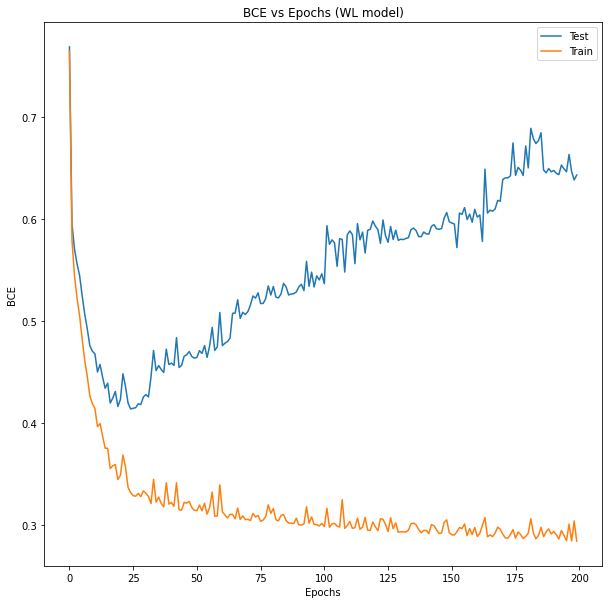

In [ ]:
# plot the loss
plt.figure(figsize=(10, 10))
plt.plot(WL_test_losses, label='Test')
plt.plot(WL_train_losses, label='Train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('BCE')
plt.title('BCE vs Epochs (WL model)')

### After training the models, we can see that there is some obvious overfitting, therefore we recover the model weights that yielded the best test errors.

In [ ]:
wl_model.load_state_dict(torch.load('best_wl_model.pt'))
# pts_model.load_state_dict(torch.load('best_pts_model.pt'))

<All keys matched successfully>

In [ ]:
wlpredictions = (wl_model(XTest) > 0.5)
wlaccuracy = (wlpredictions == YTest[:, 0:1]).sum()/YTest.shape[0]

In [ ]:
print(f"The model's prediction on Win/Loss was {wlaccuracy.item()*100:.2f}% correct")

The model's prediction on Win/Loss was 80.88% correct


The model's performance on the test set performed worse than the Baseline Logistic Regression Model and so further analysis shall not be continued.

##Third model: xgBoost

# Predict points

In [ ]:
#Define a function to create baseline model
def baseline_pts(data,y,model,cv,xgb_plt):
#Loop through each validation split
    fold = 1
    fold_metrics_rmse=[]
    for train_index,test_index in cv.split(data,data[y]):
        #Get training and test data for each split
        cv_train,cv_test=data.iloc[train_index],data.iloc[test_index]
        cv_x_train, cv_y_train = cv_train.iloc[:,:-1],cv_train.iloc[:,-1]
        cv_x_test, cv_y_test = cv_test.iloc[:,:-1],cv_test.iloc[:,-1]
        #if norm:
          # Feature Scaling
          #cv_x_train = normalizator_scaler(cv_x_train)
          #cv_x_test = normalizator_scaler(cv_x_test)
        #Fit the model
        model.fit(cv_x_train, cv_y_train)
        #Make prediction
        predictions=model.predict(cv_x_test)
        # RMSE Computation
        rmse = np.sqrt(MSE(cv_y_test,predictions))
        fold_metrics_rmse.append(rmse)
        print('Fold: {}'.format(fold))
        print('CV train shape: {}'.format(cv_train.shape))
        fold += 1
    print('\nRMSE in each cross validation = ',fold_metrics_rmse,'\nmean = ',np.mean(fold_metrics_rmse),'\nstd = ',np.std(fold_metrics_rmse),'\nmean-std =',np.mean(fold_metrics_rmse)-np.std(fold_metrics_rmse))
    if xgb_plt:
      plt.rcParams['figure.figsize'] = (10.0, 8)
      # Plot feature importance for xbg
      xgb.plot_importance(model)
      # Plot gain instead of weight
      xgb.plot_importance(model, importance_type="gain")

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fold: 1
CV train shape: (12508, 13)
Fold: 2
CV train shape: (12509, 13)
Fold: 3
CV train shape: (12509, 13)
Fold: 4
CV train shape: (12509, 13)
Fold: 5
CV train shape: (12509, 13)

RMSE in each cross validation =  [6.8363738082366385, 6.913641729626337, 6.789097533943859, 6.697808230869353, 6.762796039209961] 
mean =  6.799943468377229 
std =  0.07236523585479826 
mean-std = 6.727578232522431


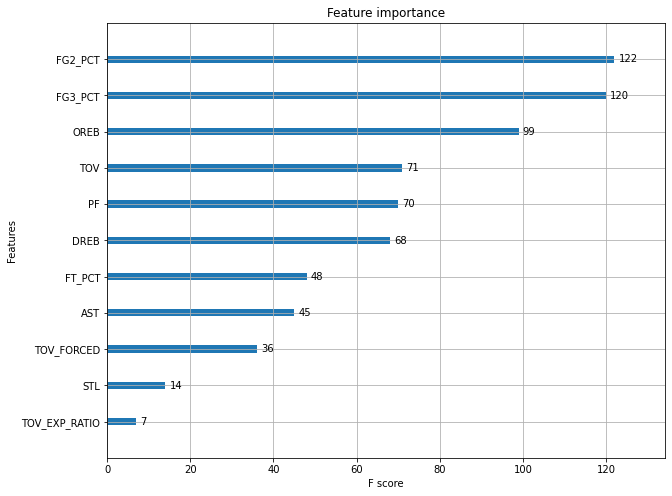

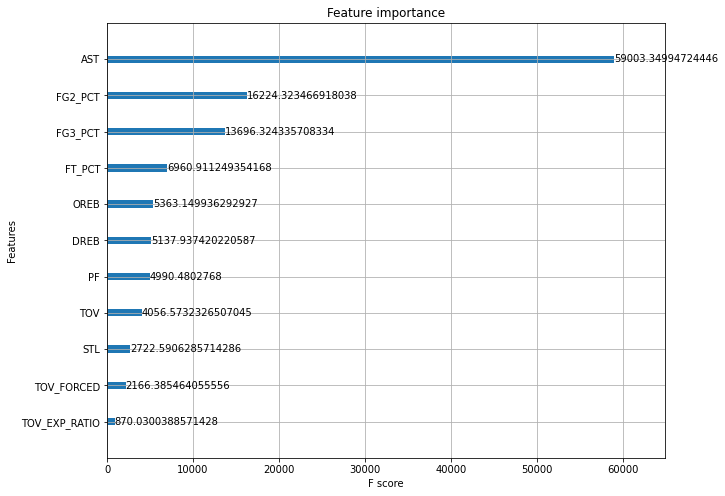

In [ ]:
cv=StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)
xgb_r = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 1234)
#Points prediction
data = allGamesPureData [['FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'PF', 'TOV',
       'TOV_FORCED', 'FG2_PCT', 'TOV_EXP_RATIO','PTS']]
baseline_pts(data,'PTS', xgb_r, cv, True)

In [ ]:

rs_param_grid = {
    'max_depth': [5,8],
    'alpha': [0,0.1,0.5],
    'eta' : [0.05,0.1,0.15],
    'n_estimators': list((range(130,170,10))),
    'objective': ['reg:squarederror'],
    'eval_metric': ['rmse'],
    'min_child_weight' : [4,7],
    'seed' : [1234],
    'gamma' :[0.3,0.5],
    'feature_selector':['greedy']
    }
#rs_param_grid = {'alpha': [0], 'eta': [0.05], 'eval_metric': ['rmse'], 'feature_selector': ['greedy'], 'gamma': [0.3], 'max_depth': [5], 'min_child_weight': [4], 'n_estimators': [130], 'objective': ['reg:squarederror'], 'seed': [1234]}
# Instantiate GridSearchCV()
xgb_rs = GridSearchCV(estimator=xgb_r, param_grid=rs_param_grid, cv=cv, verbose=2,scoring='neg_root_mean_squared_error')

# Train the model on the training set
xgb_rs.fit(task2XTrain, task2YTrain['PTS'])

# Print the best parameters and highest accuracy
print("Best parameters found:", xgb_rs.best_params_)
print("Best RMSE found:", abs(xgb_rs.best_score_)) #The best score found is the one corresponding to the best cross-validation rmse found

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV] END alpha=0, eta=0.05, eval_metric=rmse, feature_selector=greedy, gamma=0.3, max_depth=5, min_child_weight=4, n_estimators=130, objective=reg:squarederror, seed=1234; total time=   1.3s
[CV] END alpha=0, eta=0.05, eval_metric=rmse, feature_selector=greedy, gamma=0.3, max_depth=5, min_child_weight=4, n_estimators=130, objective=reg:squarederror, seed=1234; total time=   1.2s
[CV] END alpha=0, eta=0.05, eval_metric=rmse, feature_selector=greedy, gamma=0.3, max_depth=5, min_child_weight=4, n_estimators=130, objective=reg:squarederror, seed=1234; total time=   1.3s
[CV] END alpha=0, eta=0.05, eval_metric=rmse, feature_selector=greedy, gamma=0.3, max_depth=5, min_child_weight=4, n_estimators=130, objective=reg:squarederror, seed=1234; total time=   1.3s
[CV] END alpha=0, eta=0.05, eval_metric=rmse, feature_selector=greedy, gamma=0.3, max_depth=5, min_child_weight=4, n_estimators=130, objective=reg:squarederror, seed=1234; total time=   1.3s
[CV] END alpha=0, eta=0.05, eval_metric=rmse,

In [ ]:
#Try it on on splitted test data
best2=xgb_rs.best_estimator_
preds_splitted=best2.predict(task2XTest)

#Calculate metrics of interest
MSE_test = np.sqrt(MSE(task2YTest['PTS'],preds_splitted))

#See how the model performed on train and test data (way to spot probable overfitting)
train_pred = best2.predict(task2XTrain)
MSE_train = np.sqrt(MSE(task2YTrain['PTS'], train_pred))

print('MSE Train: {:.3f}. MSE Test: {:.3f}'.format(MSE_train, MSE_test))

MSE Train: 5.256. MSE Test: 6.434


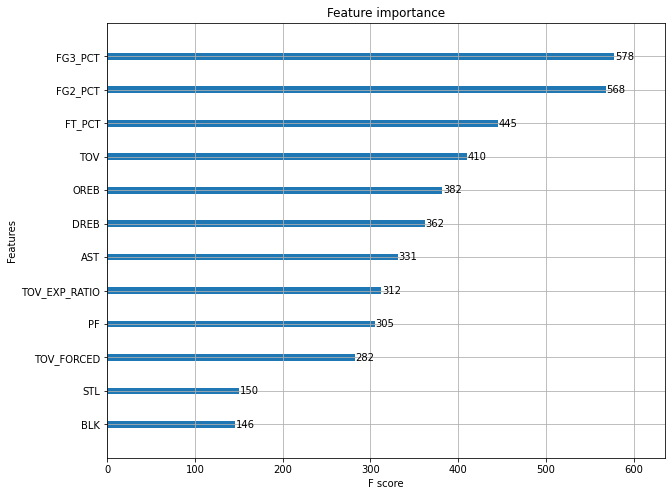

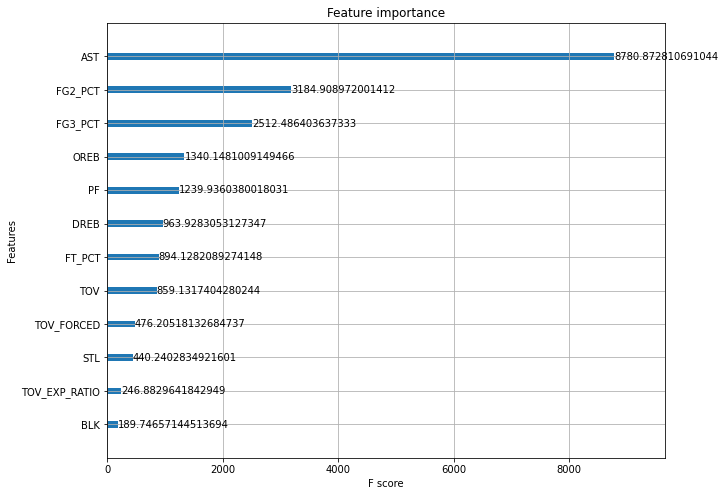

In [ ]:
#Feature importance
plt.rcParams['figure.figsize'] = (10.0, 8)
# Plot feature importance for xbg
xgb.plot_importance(best2)
# Plot gain instead of weight
xgb.plot_importance(best2, importance_type="gain")

##Predict win/loss

In [ ]:
#Define a function to create baseline model
def baseline(data,y,model,cv,xgb_plt):
#Loop through each validation split
    fold = 1
    fold_metrics_acc=[]
    fold_metrics_f1=[]
    for train_index,test_index in cv.split(data,data[y]):
        #Get training and test data for each split
        cv_train,cv_test=data.iloc[train_index],data.iloc[test_index]
        cv_x_train, cv_y_train = cv_train.iloc[:,:-1],cv_train.iloc[:,-1]
        cv_x_test, cv_y_test = cv_test.iloc[:,:-1],cv_test.iloc[:,-1]
        #if norm:
          # Feature Scaling
          #cv_x_train = normalizator_scaler(cv_x_train)
          #cv_x_test = normalizator_scaler(cv_x_test)
        #Fit the model
        model.fit(cv_x_train, cv_y_train)
        #Make prediction
        predictions=model.predict(cv_x_test)
        #Compute accuracy
        acc= accuracy_score(cv_y_test,predictions)
        fold_metrics_acc.append(acc)
        #Compute f1
        f1= f1_score(cv_y_test,predictions)
        fold_metrics_f1.append(f1)
        print('Fold: {}'.format(fold))
        print('CV train shape: {}'.format(cv_train.shape))
        fold += 1
    print('\naccuracy in each cross validation = ',fold_metrics_acc,'\nmean = ',np.mean(fold_metrics_acc),'\nstd = ',np.std(fold_metrics_acc),'\nmean-std =',np.mean(fold_metrics_acc)-np.std(fold_metrics_acc))
    print('\nf1 score in each cross validation = ',fold_metrics_f1,'\nmean = ',np.mean(fold_metrics_f1),'\nstd = ',np.std(fold_metrics_f1),'\nmean-std =',np.mean(fold_metrics_f1)-np.std(fold_metrics_f1))
    if xgb_plt:
      plt.rcParams['figure.figsize'] = (10.0, 8)
      # Plot feature importance for xbg
      xgb.plot_importance(model)
      # Plot gain instead of weight
      xgb.plot_importance(model, importance_type="gain")

In [ ]:
task2X.columns

Index(['FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'PF', 'TOV',
       'TOV_FORCED', 'FG2_PCT', 'TOV_EXP_RATIO'],
      dtype='object')

Fold: 1
CV train shape: (12508, 12)
Fold: 2
CV train shape: (12509, 12)
Fold: 3
CV train shape: (12509, 12)
Fold: 4
CV train shape: (12509, 12)
Fold: 5
CV train shape: (12509, 12)

accuracy in each cross validation =  [0.8158567774936062, 0.8042852574352415, 0.8250719539494723, 0.818676047329709, 0.818676047329709] 
mean =  0.8165132167075477 
std =  0.006819993492422176 
mean-std = 0.8096932232151256

f1 score in each cross validation =  [0.8143133462282399, 0.8018134715025907, 0.8226904376012967, 0.8178605846450369, 0.8154897494305239] 
mean =  0.8144335178815376 
std =  0.006932779338449009 
mean-std = 0.8075007385430886


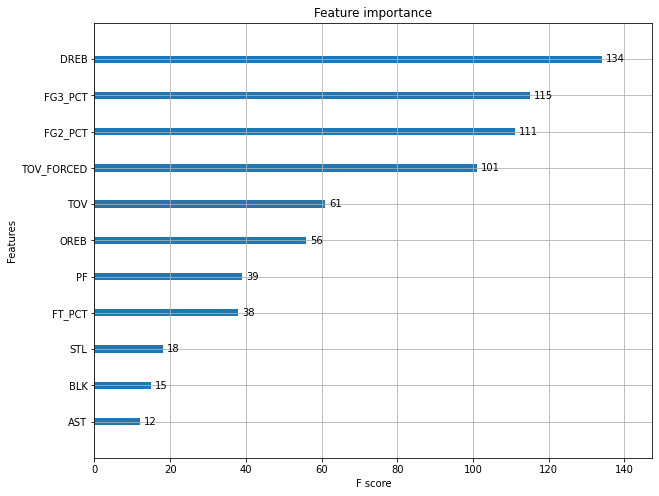

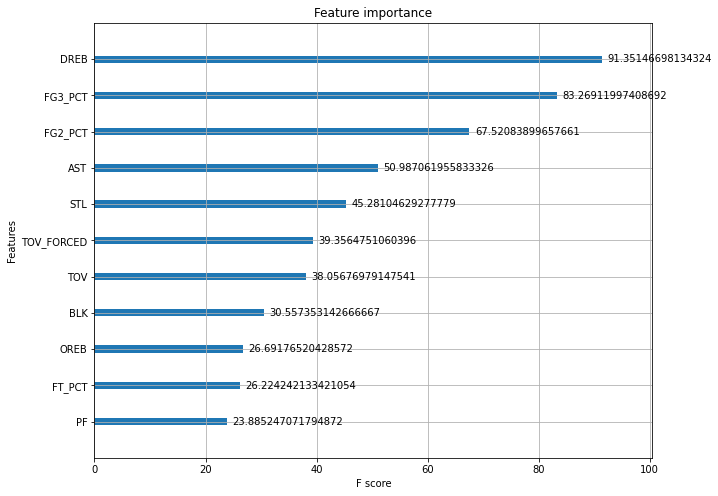

In [ ]:
cv=StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)
#First baseline model
xgb_clf = xgb.XGBClassifier()

#Win/Loss prediction
data = allGamesPureData[['FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'PF', 'TOV',
       'TOV_FORCED', 'FG2_PCT','WL']]
#Baseline model with non-normalized data 
baseline(data,'WL', xgb_clf, cv,True)

Fold: 1
CV train shape: (12508, 13)
Fold: 2
CV train shape: (12509, 13)
Fold: 3
CV train shape: (12509, 13)
Fold: 4
CV train shape: (12509, 13)
Fold: 5
CV train shape: (12509, 13)

accuracy in each cross validation =  [0.8286445012787724, 0.8199552286536617, 0.8237927726255196, 0.818676047329709, 0.8349856092101056] 
mean =  0.8252108318195536 
std =  0.0059945312382845934 
mean-std = 0.8192163005812689

f1 score in each cross validation =  [0.82798459563543, 0.817148424813251, 0.8212779759974052, 0.8172736061875604, 0.8327932598833441] 
mean =  0.8232955725033981 
std =  0.006169525138849426 
mean-std = 0.8171260473645487


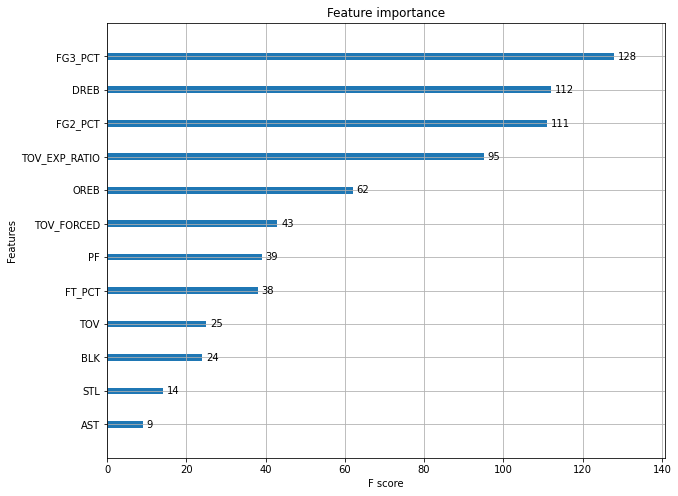

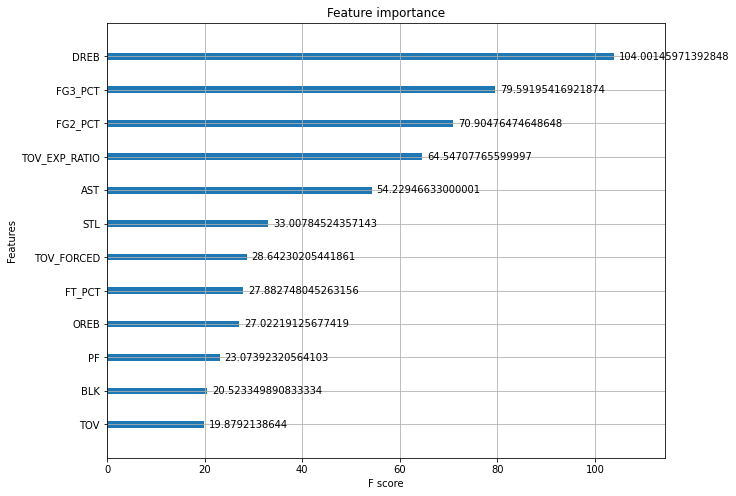

In [ ]:
# Run the same baseline model with points of turnovers feature
#Win/Loss prediction
data = allGamesPureData[['FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'AST', 'STL', 'BLK', 'PF', 'TOV',
       'TOV_FORCED', 'FG2_PCT', 'TOV_EXP_RATIO','WL']]
#Baseline model with non-normalized data 
baseline(data,'WL', xgb_clf, cv,True)

Conclusion: When having only forced_turnovers in the model we notice that forced_turnovers by itself is very important but when you put the ratio in the model as well, the significance of forced_turnovers drops and gives higher significance to the ratio. This essentially means that what is more important is for a team to actually be able to convert those forced turnovers to actual points in its favor

In [ ]:
#Since there is not a significant im
cv=StratifiedKFold(n_splits=5,shuffle=True, random_state=1234)
'''
rs_param_grid = {
    'max_depth': [3,5,7],
    'eta' : [0.05,0.1],
    'n_estimators': list((range(50,71,5))),
    'max_delta_step' : [1,2,3],
    'objective': ['binary:logistic'],
    'eval_metric': ['error'],
    'min_child_weight' : [4,5,7,8],
    'seed' : [1234],
    'gamma' :[0.3,0.5,0.7],
    'early_stopping_rounds':[6,10]
    }
'''
#Best parameters found (run for quick results otherwise run the grid above currently commented)
rs_param_grid = {'early_stopping_rounds': [6],
                 'eta': [0.05],
                 'eval_metric': ['error'],
                 'gamma': [0.5],
                 'max_delta_step': [1],
                 'max_depth': [7],
                 'n_estimators': [70],
                 'objective': ['binary:logistic'],
                 'seed': [1234],
                  'min_child_weight' : [5]}

# Instantiate GridSearchCV()
xgb_rs = GridSearchCV(estimator=xgb_clf, param_grid=rs_param_grid, cv=cv, verbose=2,scoring='accuracy')

# Train the model on the training set
xgb_rs.fit(task2XTrain, task2YTrain['WL'])

# Print the best parameters and highest accuracy
print("Best parameters found:", xgb_rs.best_params_)
print("Best accuracy found:", xgb_rs.best_score_) #The best score found is the one corresponding to the best cross-validation rmse found

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END early_stopping_rounds=6, eta=0.05, eval_metric=error, gamma=0.5, max_delta_step=1, max_depth=7, min_child_weight=5, n_estimators=70, objective=binary:logistic, seed=1234; total time=   1.1s
[CV] END early_stopping_rounds=6, eta=0.05, eval_metric=error, gamma=0.5, max_delta_step=1, max_depth=7, min_child_weight=5, n_estimators=70, objective=binary:logistic, seed=1234; total time=   1.1s
[CV] END early_stopping_rounds=6, eta=0.05, eval_metric=error, gamma=0.5, max_delta_step=1, max_depth=7, min_child_weight=5, n_estimators=70, objective=binary:logistic, seed=1234; total time=   1.1s
[CV] END early_stopping_rounds=6, eta=0.05, eval_metric=error, gamma=0.5, max_delta_step=1, max_depth=7, min_child_weight=5, n_estimators=70, objective=binary:logistic, seed=1234; total time=   1.1s
[CV] END early_stopping_rounds=6, eta=0.05, eval_metric=error, gamma=0.5, max_delta_step=1, max_depth=7, min_child_weight=5, n_estimators=70, obj

task2XTrain, task2XTest, task2YTrain, task2YTest

In [ ]:
#Try it on on splitted test data
best=xgb_rs.best_estimator_
preds_splitted=best.predict(task2XTest)

#Calculate metrics of interest
acc_test = accuracy_score(task2YTest['WL'],preds_splitted)
f1_test = f1_score(task2YTest['WL'],preds_splitted)

#See how the model performed on train and test data (way to spot probable overfitting)
train_pred = best.predict(task2XTrain)
acc_train = accuracy_score(task2YTrain['WL'], train_pred)                  
f1_train = f1_score(task2YTrain['WL'], train_pred)                  

print('acc Train: {:.3f}. acc Test: {:.3f}'.format(acc_train, acc_test))
print('f1 Train: {:.3f}. f1 Test: {:.3f}'.format(f1_train, f1_test))

acc Train: 0.911. acc Test: 0.821
f1 Train: 0.910. f1 Test: 0.819


Best Threshold=0.426916, F-Score=0.824


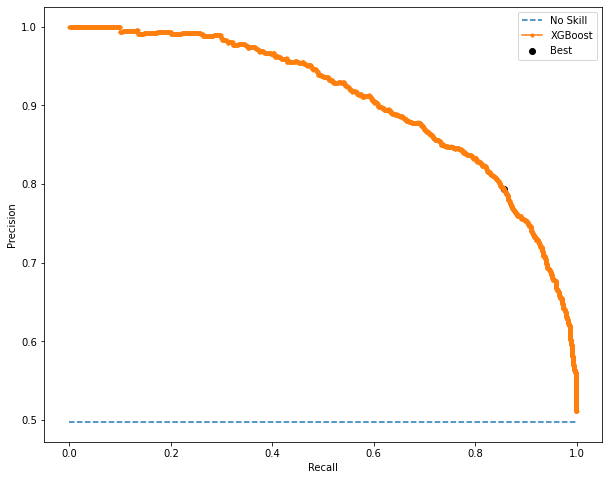

In [ ]:
# Which threshold would achieve the best result?
# optimal threshold for precision-recall curve with XGBoost model

# Predict probabilities and keep probabilities for the bankrupt only
probs = best.predict_proba(task2XTest)[:,1]
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(task2YTest['WL'], probs)
# convert to f1 score
f1 = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(f1)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], f1[ix]))
# plot the roc curve for the model
no_skill = len(task2YTest['WL'][task2YTest['WL']==1]) / len(task2YTest['WL'])
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [ ]:
#Change the threshold (optional)
max_acc=0
max_acc_thres=0
max_f1=0
max_f1_thres=0
i=0.3
while i<=0.70: 
    preds_splitted2=(best.predict_proba(task2XTest)[:,1]>=i).astype(int)
    acc_comp=accuracy_score(task2YTest['WL'],preds_splitted2)
    if acc_comp>=max_acc:
        max_acc=acc_comp
        max_acc_thres=i
    f1_comp=f1_score(task2YTest['WL'],preds_splitted2)
    if f1_comp>=max_f1:
        max_f1=f1_comp
        max_f1_thres=i
    i=i+0.001
print('accuracy best= ',max_acc,' with threshold = ',max_acc_thres)
print('f1 score best= ',max_f1,' with threshold = ',max_f1_thres)
preds_splitted2=(best.predict_proba(task2XTest)[:,1]>=max_f1_thres).astype(int)
print('accuracy score of best f1 score threshold = ',accuracy_score(task2YTest['WL'],preds_splitted2))

accuracy best=  0.8225703324808185  with threshold =  0.48900000000000016
f1 score best=  0.824413145539906  with threshold =  0.4500000000000001
accuracy score of best f1 score threshold =  0.8206521739130435


In [ ]:
#The results of the chosen threshold on the train set
train_pred2 = (best.predict_proba(task2XTrain)[:,1]>=max_acc_thres).astype(int)
print('train test accuracy (best f1 threshold) = ', accuracy_score(task2YTrain['WL'], train_pred2))              
print('train test f1 (best threshold) = ', f1_score(task2YTrain['WL'], train_pred2))

train test accuracy (best f1 threshold) =  0.9106172049888072
train test f1 (best threshold) =  0.9102008032128514


In [ ]:
#Use preds_splitted2 if you have changed threshold. Shows metrics of train up and test down (for comparison)
from sklearn.metrics import classification_report
print(classification_report(task2YTest['WL'], preds_splitted2))

              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1572
           1       0.80      0.85      0.82      1556

    accuracy                           0.82      3128
   macro avg       0.82      0.82      0.82      3128
weighted avg       0.82      0.82      0.82      3128



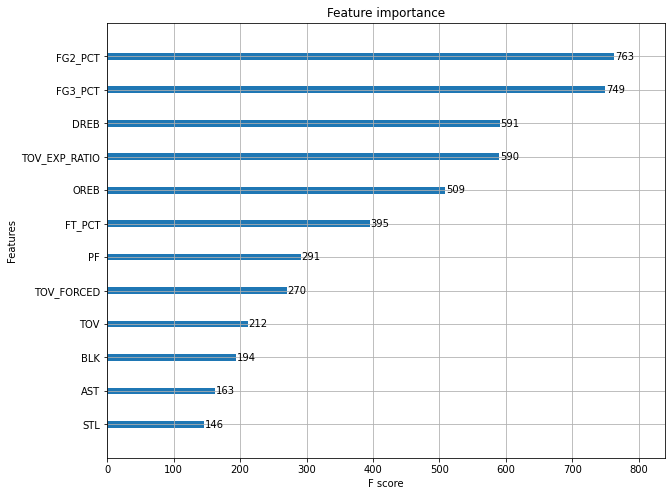

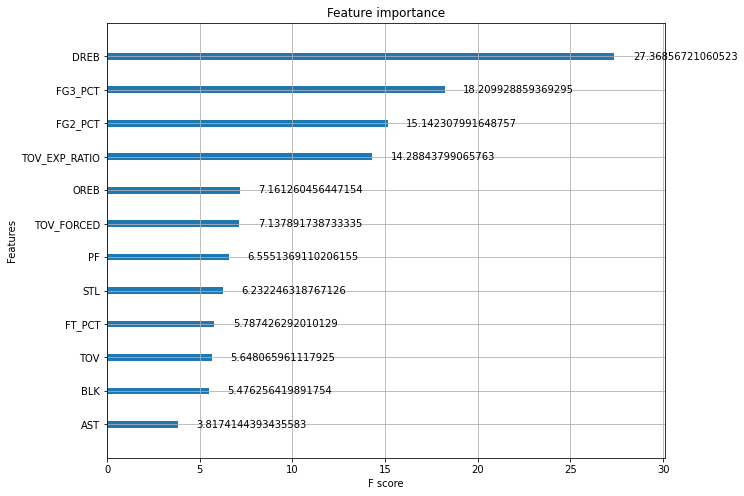

In [ ]:
#Feature importance
plt.rcParams['figure.figsize'] = (10.0, 8)
# Plot feature importance for xbg
xgb.plot_importance(best)
# Plot gain instead of weight
xgb.plot_importance(best, importance_type="gain")

In [ ]:
# Visualize the decision tree
plt.rcParams['figure.figsize'] = (100, 300)
xgb.plot_tree(best, rankdir='LR')
plt.show()